In [1]:
import sys
sys.path.append('..')

import os
import pickle
from glob import glob
import argparse
from multiprocessing import Pool

import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib import font_manager
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.ticker as mtick

from tqdm import tqdm

from scipy.optimize import curve_fit

from units import *
from cdisk_analysis import *

In [2]:
def plot_disk(r, phi, density, parameters, host_star_coords=None, satellite_coords=None, cmap='gist_heat', vmin=1e-3, vmax=1e4):
    font_path =  '../IBMPlexMono-Regular.ttf'  # Your font path goes here
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    plt.rcParams['savefig.facecolor'] = (1.0, 1.0, 1.0)
    
    ymax = parameters['YMAX'] * cm_to_AU 
    ymin = parameters['YMIN'] * cm_to_AU
    
    mg_phi, mg_r = np.meshgrid(phi, r)

    mg_x = mg_r*np.cos(mg_phi) * cm_to_AU / ymax
    mg_y = mg_r*np.sin(mg_phi) * cm_to_AU / ymax

    cmap = plt.get_cmap(cmap)
    fig,ax = plt.subplots(figsize=(5,5))

    img = ax.pcolormesh(mg_x, mg_y, density, cmap=cmap, shading='flat', snap=True, norm=LogNorm(vmin=vmin, vmax=vmax))

    if host_star_coords is not None:
        # host star coordinate x,y
        hsc_x = host_star_coords[0] * cm_to_AU / ymax
        hsc_y = host_star_coords[1] * cm_to_AU / ymax

        # truncated host star coordinate
        # this is so that we draw a line from 0 to ymax instead of to some far away distance
        # makes the plotting pretty
        host_star_angle = np.arctan2(hsc_y, hsc_x)
        thsc_x = np.cos(host_star_angle)
        thsc_y = np.sin(host_star_angle)

        ax.plot([0,thsc_x], [0,thsc_y], linestyle='--', color='black', markersize=12, linewidth=1)

    if satellite_coords is not None:
        sc_x = satellite_coords[0] * cm_to_AU / ymax
        sc_y = satellite_coords[1] * cm_to_AU / ymax
        ax.plot(sc_x, sc_y, marker='x', linestyle='none', color='black', markersize=14)

    #outer_circle = plt.Circle((0, 0), ymax, ec='black', linewidth=0.8, fc='none', linestyle='-', clip_on=False)
    #inner_circle = plt.Circle((0, 0), ymin, ec='black', linewidth=0.8, fc='none', linestyle='-', clip_on=False)
    outer_circle = plt.Circle((0, 0), 1, ec='black', linewidth=0.8, fc='none', linestyle='-', clip_on=False)
    inner_circle = plt.Circle((0, 0), ymin/ymax, ec='black', linewidth=0.8, fc='none', linestyle='-', clip_on=False)
    #r_hill_frac_circle = plt.Circle((0, 0), 0.3, ec='black', linewidth=1.2, fc='none', linestyle='-', alpha=0.5, clip_on=False)
    
    ax.add_patch(outer_circle)
    ax.add_patch(inner_circle)
    #ax.add_patch(r_hill_frac_circle)

    cbar = fig.colorbar(img, ax=ax, shrink=0.8, pad=0.05)
    cbar.set_label('Density [g/cm$^2$]')
    cbar.ax.tick_params(labelsize=9)
    ax.set_aspect("equal")
    #ax.set_xlim(-ymax, ymax)
    #ax.set_ylim(-ymax, ymax)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.linspace(-1, 1, 9))
    ax.set_xlabel('[${r}/{r_h}$]')
    ax.tick_params(axis="x", direction="inout", labelsize=9)
    ax.spines['bottom'].set_position(('outward', 15))

    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, img

# Jupiter Quasi Steady-State

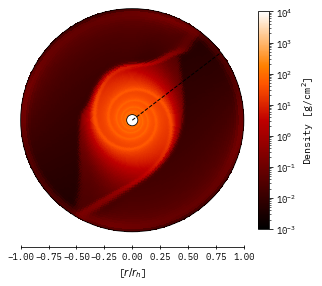

In [3]:
i=22769
prepath = str(os.path.expanduser('~'))
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'jupiter')
parameters = read_parameters(run_folder)
phi, r, density = read_fargo_data(i, run_folder, parameters)

star_planet_data_path = os.path.join(run_folder,'planet0.dat')
star_orbit_data_path = os.path.join(run_folder,'orbit0.dat')

star, star_orbit = read_planet_orbit_data(star_planet_data_path, star_orbit_data_path)

fig, img = plot_disk(r, phi, density, parameters, host_star_coords=(star['x'][i],star['y'][i]), satellite_coords=None, cmap='gist_heat')
fig.show()
fig.savefig('jupiter_quasi.pdf', bbox_inches='tight')

In [4]:
font_path =  '../IBMPlexMono-Regular.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=('#6699CC', '#004488', '#EECC66', '#994455', '#997700', '#EE99AA', '#000000'))

In [5]:
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'jupiter')
parameters = read_parameters(run_folder)

with open('disk_mass_jupiter.npy', 'rb') as f:
    disk_mass = np.load(f)

dt = parameters['DT']
times = dt * np.arange(0, len(disk_mass), 1)

scaled_times = times * sec_to_yr
scaled_disk_mass = disk_mass * g_to_MJ

In [6]:
def exp_decay(x, c, k, offset):
    return c*(1 - np.exp(-k*x) ) + offset

popt, pcov = curve_fit(exp_decay, scaled_times, scaled_disk_mass)
print(popt)

/tmp/ipykernel_10908/2377464997.py:2: RuntimeWarning: overflow encountered in exp
  return c*(1 - np.exp(-k*x) ) + offset


[4.93328000e-05 3.88182506e-03 1.93020503e-04]


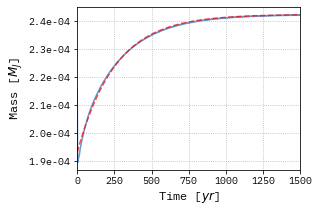

In [7]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot(scaled_times, scaled_disk_mass, label='PDS 70c')
ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

#reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

ax.set_xlim(0,1500)

#ax.set_xticks(np.linspace(0,50000,6))
#ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Time [$yr$]', fontsize=12)
ax.set_ylabel('Mass [$M_J$]', fontsize=12)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.grid(linestyle=':')

fig.show()
fig.savefig('jupiter_disk_mass.pdf', bbox_inches='tight')

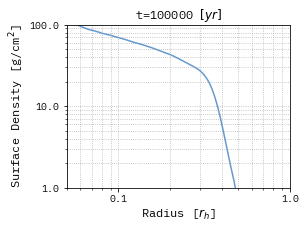

In [8]:
fig,ax = plt.subplots(figsize=(4,3))
ax.plot((r[:-1]+(r[1:]-r[:-1]))/parameters['YMAX'], np.mean(density, axis=1), label='PDS 70c')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1/20,1)
ax.set_ylim(1,1e2)

#ax.set_xticks(np.linspace(0,50000,6))
#ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Radius [$r_h$]', fontsize=12)
ax.set_ylabel('Surface Density [g/cm$^2$]', fontsize=12)

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
ax.grid(linestyle=':', which='both')
ax.set_title('t=100000 $[yr]$')
fig.show()
fig.savefig('jupiter_profile.pdf', bbox_inches='tight')

# Viscosity

Time [yr] 0.0


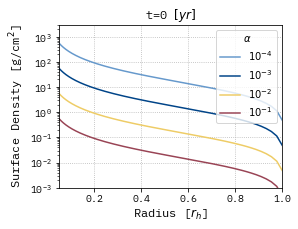

Time [yr] 49998.08188363419


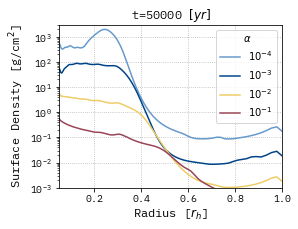

Time [yr] 99998.39582449534


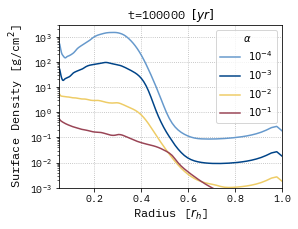

In [9]:
viscosity_files = list(sorted(glob('../data/disk_mass_pds70c_a*')))[::-1]
names = ['$10^{-'+os.path.basename(el).split('_')[-1][1:-4] + '}$' for el in viscosity_files]
basenames = [os.path.basename(el)[10:-4] for el in viscosity_files]

prepath = str(os.path.expanduser('~'))
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,basenames[0])
parameters = read_parameters(run_folder)

times = [0, 50000, 100000]
for j,index in enumerate([0, int(parameters['NTOT']/2), parameters['NTOT'] ]):
    fig,ax = plt.subplots(figsize=(4,3))
    print('Time [yr]', index * parameters['DT'] * sec_to_yr)
    for i,bn in enumerate(basenames):
        prepath = str(os.path.expanduser('~'))
        data_folder = prepath+'/landing/data/cdisk_data'
        run_folder = os.path.join(data_folder,bn)
        parameters = read_parameters(run_folder)
        phi, r, density = read_fargo_data(index, run_folder, parameters)

        ax.plot((r[:-1]+(r[1:]-r[:-1]))/parameters['YMAX'], np.mean(density, axis=1), label=names[i])

        #ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlim(1/20,1)
        ax.set_ylim(1e-3,3e3)

        #ax.set_xticks(np.linspace(0,50000,6))
        #ax.set_yticks(np.linspace(0.00250,0.0050,6))

        ax.set_xlabel('Radius [$r_h$]', fontsize=12)
        ax.set_ylabel('Surface Density [g/cm$^2$]', fontsize=12)

        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))
        ax.grid(linestyle=':')
        
        ax.set_title('t={} $[yr]$'.format(times[j]))
        ax.legend(title='$\\alpha$', fancybox=True)
        fig.savefig('viscosity_surface_density_'+str(index)+'.pdf', bbox_inches='tight')
        
    plt.show()

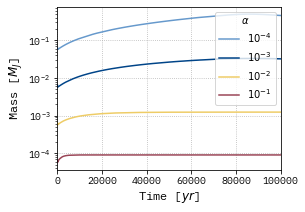

In [10]:
fig,ax = plt.subplots(figsize=(4,3))
for i,el in enumerate(viscosity_files):
    
    data_folder = prepath+'/landing/data/cdisk_data'
    run_folder = os.path.join(data_folder,basenames[i])
    parameters = read_parameters(run_folder)
    
    with open(el, 'rb') as f:
        disk_mass = np.load(f)

    dt = parameters['DT']
    times = dt * np.arange(0, len(disk_mass), 1)

    scaled_times = times * sec_to_yr
    scaled_disk_mass = disk_mass * g_to_MJ

    ax.plot(scaled_times, scaled_disk_mass, label=names[i])
    #ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

    #reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

    ax.set_xlim(0,1e5)

    ax.set_yscale('log')
    
    #ax.set_xticks(np.linspace(0,50000,6))
    #ax.set_yticks(np.linspace(0.00250,0.0050,6))

    ax.set_xlabel('Time [$yr$]', fontsize=12)
    ax.set_ylabel('Mass [$M_J$]', fontsize=12)

    #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    ax.grid(linestyle=':')
    
ax.legend(loc='upper right', title='$\\alpha$')

fig.savefig('viscosity_disk_mass.pdf', bbox_inches='tight')
fig.show()


# Mass Accretion

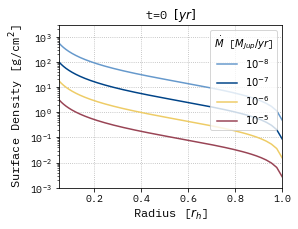

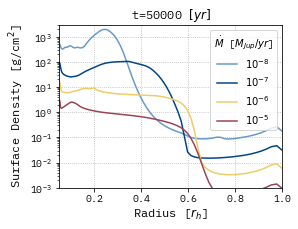

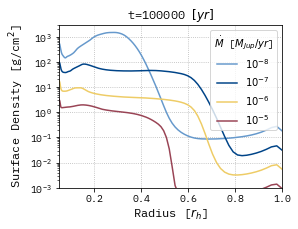

In [11]:
mass_accretion_files = list(sorted(glob('../data/disk_mass_pds70c_ma*')))[::-1]
names = ['$10^{-'+os.path.basename(el).split('_')[-1][2:-4] + '}$' for el in mass_accretion_files]
basenames = [os.path.basename(el)[10:-4] for el in mass_accretion_files]

times = [0, 50000, 100000]
for j,index in enumerate([0, int(parameters['NTOT']/2), parameters['NTOT'] ]):
    fig,ax = plt.subplots(figsize=(4,3))
    for i,bn in enumerate(basenames):
        prepath = str(os.path.expanduser('~'))
        data_folder = prepath+'/landing/data/cdisk_data'
        run_folder = os.path.join(data_folder,bn)
        parameters = read_parameters(run_folder)
        phi, r, density = read_fargo_data(index, run_folder, parameters)

        ax.plot((r[:-1]+(r[1:]-r[:-1]))/parameters['YMAX'], np.mean(density, axis=1), label=names[i])

        #ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlim(1/20,1)
        ax.set_ylim(1e-3,3e3)

        #ax.set_xticks(np.linspace(0,50000,6))
        #ax.set_yticks(np.linspace(0.00250,0.0050,6))

        ax.set_xlabel('Radius [$r_h$]', fontsize=12)
        ax.set_ylabel('Surface Density [g/cm$^2$]', fontsize=12)

        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
        ax.grid(linestyle=':')
        ax.set_title('t={} $[yr]$'.format(times[j]))
        ax.legend(fancybox=True, title='$\dot{M}$ [$M_{Jup}/yr$]')
        fig.savefig('mass_accretion_surface_density_'+str(index)+'.pdf', bbox_inches='tight')
        fig.show()

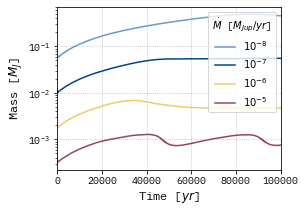

In [12]:
fig,ax = plt.subplots(figsize=(4,3))
for i,el in enumerate(mass_accretion_files):
    
    data_folder = prepath+'/landing/data/cdisk_data'
    run_folder = os.path.join(data_folder,basenames[i])
    parameters = read_parameters(run_folder)
    
    with open(el, 'rb') as f:
        disk_mass = np.load(f)

    dt = parameters['DT']
    times = dt * np.arange(0, len(disk_mass), 1)

    scaled_times = times * sec_to_yr
    scaled_disk_mass = disk_mass * g_to_MJ

    ax.plot(scaled_times, scaled_disk_mass, label=names[i])
    #ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

    #reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

    ax.set_xlim(0,1e5)
    ax.set_yscale('log')
    
    #ax.set_xticks(np.linspace(0,50000,6))
    #ax.set_yticks(np.linspace(0.00250,0.0050,6))

    ax.set_xlabel('Time [$yr$]', fontsize=12)
    ax.set_ylabel('Mass [$M_J$]', fontsize=12)

    #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    ax.grid(linestyle=':')
    
ax.legend(loc='upper right',title='$\dot{M}$ [$M_{Jup}/yr$]')

fig.savefig('mass_accretion_disk_mass.pdf', bbox_inches='tight')
fig.show()


# Planet Mass

In [13]:
prefix = '../data/disk_mass_pds70c_m'
suffix = '.npy'
planet_mass_files = [prefix+str(i)+suffix for i in range(1,14+1)][::-1]
names = ['{:>2}'.format(os.path.basename(el).split('_')[-1][1:-4]) for el in planet_mass_files]
basenames = [os.path.basename(el)[10:-4] for el in planet_mass_files]

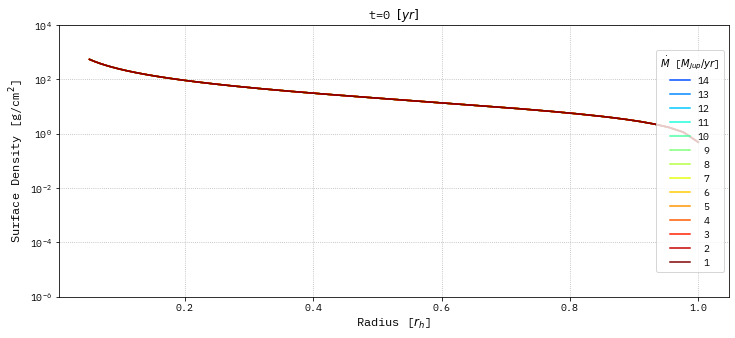

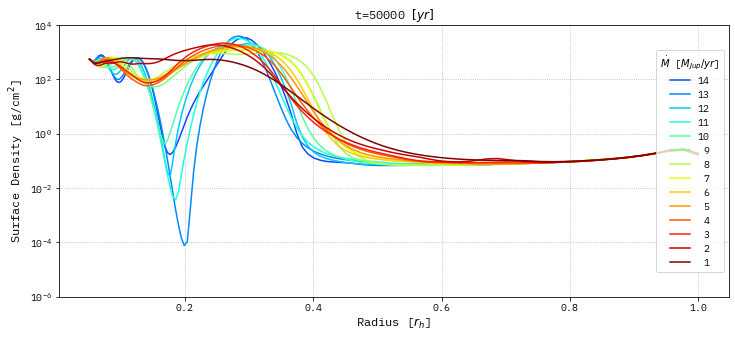

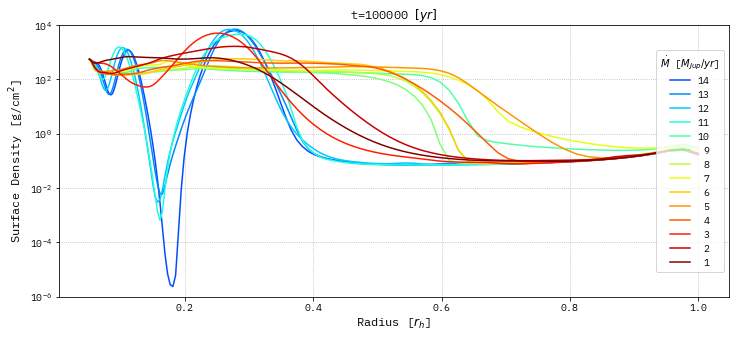

In [14]:
times = [0, 50000, 100000]
for j,index in enumerate([0, int(parameters['NTOT']/2), parameters['NTOT'] ]):
    fig,ax = plt.subplots(figsize=(12,5))
    for i,bn in enumerate(basenames):
        prepath = str(os.path.expanduser('~'))
        data_folder = prepath+'/landing/data/cdisk_data'
        run_folder = os.path.join(data_folder,bn)
        parameters = read_parameters(run_folder)
        phi, r, density = read_fargo_data(index, run_folder, parameters)

        ax.plot((r[:-1]+(r[1:]-r[:-1]))/parameters['YMAX'], np.mean(density, axis=1), label=names[i], color=cm.jet(np.linspace(0.2,1,len(planet_mass_files)))[i])

        #ax.set_xscale('log')
        ax.set_yscale('log')

        #ax.set_xlim(1/20,1)
        ax.set_ylim(1e-6,1e4)

        #ax.set_xticks(np.linspace(0,50000,6))
        #ax.set_yticks(np.linspace(0.00250,0.0050,6))

        ax.set_xlabel('Radius [$r_h$]', fontsize=12)
        ax.set_ylabel('Surface Density [g/cm$^2$]', fontsize=12)

        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
        ax.grid(linestyle=':')
        ax.set_title('t={} $[yr]$'.format(times[j]))
        ax.legend(loc='center right', fancybox=True, title='$\dot{M}$ [$M_{Jup}/yr$]')
        fig.savefig('planet_mass_surface_density_'+str(index)+'.pdf', bbox_inches='tight')
        fig.show()

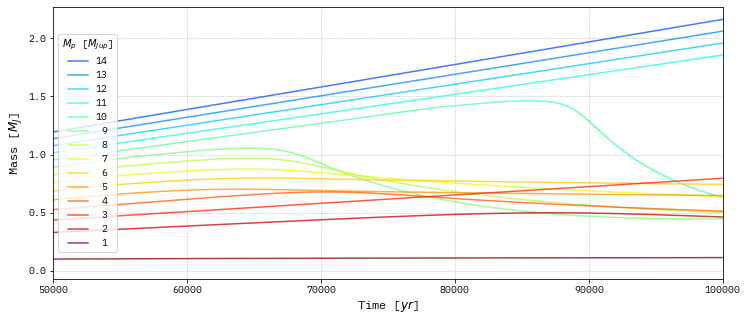

In [15]:
fig,ax = plt.subplots(figsize=(12,5))
for i,el in enumerate(planet_mass_files):
    
    data_folder = prepath+'/landing/data/cdisk_data'
    run_folder = os.path.join(data_folder,basenames[i])
    parameters = read_parameters(run_folder)
    
    with open(el, 'rb') as f:
        disk_mass = np.load(f)

    dt = parameters['DT']
    times = dt * np.arange(0, len(disk_mass), 1)

    scaled_times = times * sec_to_yr
    scaled_disk_mass = disk_mass * g_to_MJ

    ax.plot(scaled_times, scaled_disk_mass, label=names[i], alpha=0.75, color=cm.jet(np.linspace(0.2,1,len(planet_mass_files)))[i])
    #ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

    #reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

    ax.set_xlim(5e4,1e5)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    #ax.set_xticks(np.linspace(0,50000,6))
    #ax.set_yticks(np.linspace(0.00250,0.0050,6))

    ax.set_xlabel('Time [$yr$]', fontsize=12)
    ax.set_ylabel('Mass [$M_J$]', fontsize=12)

    #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    ax.grid(linestyle=':')
    
ax.legend(loc='center left', title='$M_p$ [$M_{Jup}$]')

fig.savefig('planet_mass_disk_mass.pdf', bbox_inches='tight')
fig.show()


# Nominal Plots

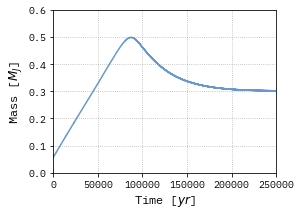

In [16]:
nominal_file = '../data/disk_mass_pds70c_nominal_long.npy'
fig,ax = plt.subplots(figsize=(4,3))
    
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'pds70c_nominal_long')
parameters = read_parameters(run_folder)

with open(nominal_file, 'rb') as f:
    disk_mass = np.load(f)

dt = parameters['DT']
times = dt * np.arange(0, len(disk_mass), 1)

scaled_times = times * sec_to_yr
scaled_disk_mass = disk_mass * g_to_MJ

ax.plot(scaled_times, scaled_disk_mass)
#ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

#reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

ax.set_xlim(0,2.5e5)
ax.set_ylim(0,0.6)
#ax.set_yscale('log')

#ax.set_xticks(np.linspace(0,50000,6))
#ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Time [$yr$]', fontsize=12)
ax.set_ylabel('Mass [$M_J$]', fontsize=12)

#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.grid(linestyle=':')
    
#ax.legend(loc='upper right',title='$\dot{M}$ [$M_{Jup}/yr$]')

fig.savefig('nominal_disk_mass.pdf', bbox_inches='tight')
fig.show()


In [17]:
np.polyfit(scaled_times[:27000], scaled_disk_mass[:27000], 1)

array([5.42382165e-06, 5.77662184e-02])

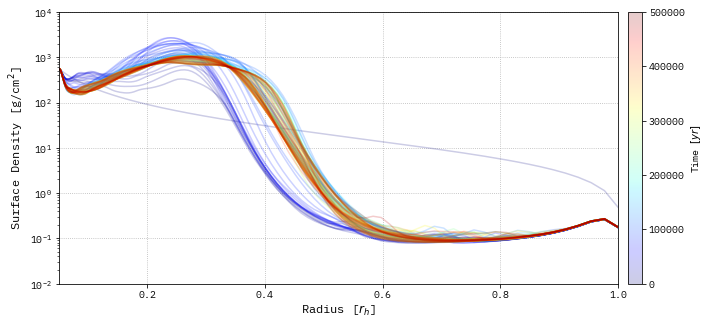

In [18]:
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'pds70c_nominal_long')
parameters = read_parameters(run_folder)

times = np.arange(0,500000+5000, 5000)
indicies = [int(el * yr_to_sec / parameters['DT']) for el in times]
fig,ax = plt.subplots(figsize=(12,5))

cmap = cm.jet
norm = Normalize(vmin=times[0],vmax=times[-1])

for j,index in enumerate(indicies):

    phi, r, density = read_fargo_data(index, run_folder, parameters)
    
    plot = ax.plot((r[:-1]+(r[1:]-r[:-1]))/parameters['YMAX'], np.mean(density, axis=1), label=times[j], alpha=0.2, color=cmap(np.linspace(0,1,len(indicies)))[j])

#ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1/20,1)
ax.set_ylim(1e-2,1e4)

#ax.set_xticks(np.linspace(0,50000,6))
#ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Radius [$r_h$]', fontsize=12)
ax.set_ylabel('Surface Density [g/cm$^2$]', fontsize=12)

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
ax.grid(linestyle=':')
#ax.set_title('t={} $[yr]$'.format(times[j]))
#ax.legend(loc='upper right', fancybox=True, title='t [$yr$]')
    
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, pad=0.015, label='Time $[yr]$')
cbar.set_alpha(0.2)
cbar.draw_all()

fig.savefig('nominal_surface_density.pdf', bbox_inches='tight')

fig.show()

# Closed System

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2690.52it/s]


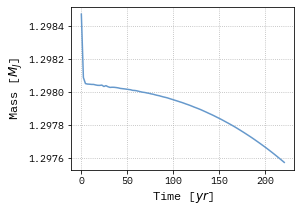

In [127]:
nominal_file = '../data/disk_mass_closed_system.npy'
fig,ax = plt.subplots(figsize=(4,3))
    
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'closed_system')
parameters = read_parameters(run_folder)

n_frames = 100
disk_mass = []
for i in tqdm(range(n_frames)):

    phi, r, density = read_fargo_data(i, run_folder, parameters)

    #diff = r[1:] - r[:-1]
    #dx = (2*np.pi/parameters['NX'])*r[1:]
    #mass = np.sum(density.T * diff*dx)
    area = np.pi * (r[1:]*r[1:] - r[:-1]*r[:-1]) / parameters['NX']
    disk_mass.append(np.sum(density.T * area))

disk_mass = np.array(disk_mass)

dt = parameters['DT']
times = dt * np.arange(0, len(disk_mass), 1)

scaled_times = times * sec_to_yr
scaled_disk_mass = disk_mass * g_to_MJ

ax.plot(scaled_times, scaled_disk_mass)
#ax.plot(scaled_times, exp_decay(scaled_times, *popt), color='red', linestyle='--', alpha=0.7)

#reduced_chi_squared = np.sum(np.power(diff, 2) / np.var(diff)) / (scaled_disk_mass.shape[0])

#ax.set_xlim(0,2.5e5)
#ax.set_ylim(0,0.6)
#ax.set_yscale('log')

#ax.set_xticks(np.linspace(0,50000,6))
#ax.set_yticks(np.linspace(0.00250,0.0050,6))

ax.set_xlabel('Time [$yr$]', fontsize=12)
ax.set_ylabel('Mass [$M_J$]', fontsize=12)

#ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.grid(linestyle=':')
    
#ax.legend(loc='upper right',title='$\dot{M}$ [$M_{Jup}/yr$]')

#fig.savefig('closed_system_disk_mass.pdf', bbox_inches='tight')
fig.show()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1755.38it/s]


In [112]:
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'closed_system')
parameters = read_parameters(run_folder)
phi, r, density = read_fargo_data(2, run_folder, parameters)

In [113]:
diff = r[1:]*r[1:] - r[:-1]*r[:-1]

In [118]:
np.polyfit(scaled_times[50:], scaled_disk_mass[50:], 1)

array([5.18372059e-06, 5.58045581e-02])

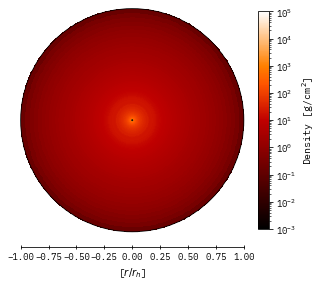

In [120]:
i=100
prepath = str(os.path.expanduser('~'))
data_folder = prepath+'/landing/data/cdisk_data'
run_folder = os.path.join(data_folder,'closed_system')
parameters = read_parameters(run_folder)
phi, r, density = read_fargo_data(i, run_folder, parameters)

star_planet_data_path = os.path.join(run_folder,'planet0.dat')
star_orbit_data_path = os.path.join(run_folder,'orbit0.dat')

#star, star_orbit = read_planet_orbit_data(star_planet_data_path, star_orbit_data_path)

fig, img = plot_disk(r, phi, density, parameters, cmap='gist_heat', vmin=1e-3, vmax=1e5)
fig.show()